##ThinkDSP

This notebook contains solutions to exercises in Chapter 4: Noise

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [4]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

**Exercise:** ``A Soft Murmur'' is a web site that plays a mixture of natural
noise sources, including rain, waves, wind, etc.  At
http://asoftmurmur.com/about/ you can find their list
of recordings, most of which are at http://freesound.org.

Download a few of these files and compute the spectrum of each
signal.  Does the power spectrum look like white noise, pink noise,
or Brownian noise?  How does the spectrum vary over time?

In [2]:
wave = thinkdsp.read_wave('rain_sound.wav')
wave.make_audio()

IOError: [Errno 2] No such file or directory: 'rain_sound.wav'

I chose a recording of ocean waves.  I selected a short segment:

In [3]:
segment = wave.segment(start=1.5, duration=1.0)
segment.make_audio()

And here's its spectrum:

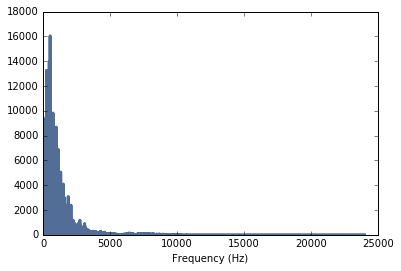

In [4]:
spectrum = segment.make_spectrum()
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)')

Amplitude drops off with frequency, so this might be red or pink noise.  We can check by looking at the power spectrum on a log-log scale.

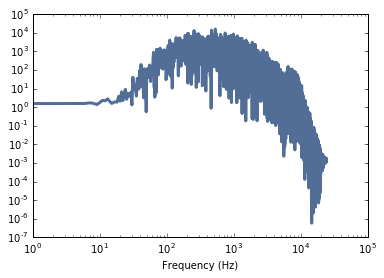

In [5]:
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)',
                 xscale='log', 
                 yscale='log')

This structure, with increasing and then decreasing amplitude, seems to be common in natural noise sources.

Above $f = 10^3$, it might be dropping off linearly, but we can't really tell.

To see how the spectrum changes over time, I'll select another segment:

In [6]:
segment2 = wave.segment(start=2.5, duration=1.0)
segment2.make_audio()

And plot the two spectrums:

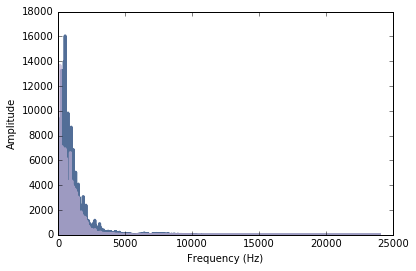

In [7]:
spectrum2 = segment2.make_spectrum()
spectrum.plot_power()
spectrum2.plot_power(color='#beaed4')
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude')

Here they are again, plotting power on a log-log scale.

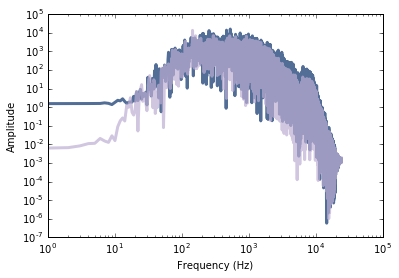

In [8]:
spectrum.plot_power()
spectrum2.plot_power(color='#beaed4')
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude',
                 xscale='log', 
                 yscale='log')

So the structure seems to be consistent over time.

We can also look at a spectrogram:

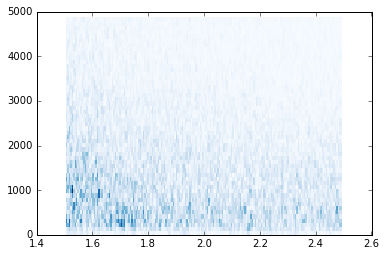

In [9]:
segment.make_spectrogram(512).plot(high=5000)

Within this segment, the overall amplitude drops off, but the mixture of frequencies seems consistent.

**Exercise:** In a noise signal, the mixture of frequencies changes over time.
In the long run, we expect the power at all frequencies to be equal,
but in any sample, the power at each frequency is random.

To estimate the long-term average power at each frequency, we can
break a long signal into segments, compute the power spectrum for each segment, and then compute the average across
the segments.  You can read more about this algorithm at
http://en.wikipedia.org/wiki/Bartlett's_method.

Implement Bartlett's method and use it to estimate the power
spectrum for a noise wave.  Hint: look at the implementation
of `make_spectrogram`.

In [10]:
def bartlett_method(wave, seg_length=512, win_flag=True):
    """Estimates the power spectrum of a noise wave.
    
    wave: Wave
    seg_length: segment length
    """
    # make a spectrogram and extract the spectrums
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    # extract the power array from each spectrum
    psds = [spectrum.power for spectrum in spectrums]
    
    # compute the root mean power (which is like an amplitude)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    # make a Spectrum with the mean amplitudes
    spectrum = thinkdsp.Spectrum(hs, fs, wave.framerate)
    return spectrum

`bartlett_method` makes a spectrogram and extracts `spec_map`, which maps from times to Spectrum objects.  It computes the PSD for each spectrum, adds them up, and puts the results into a Spectrum object.

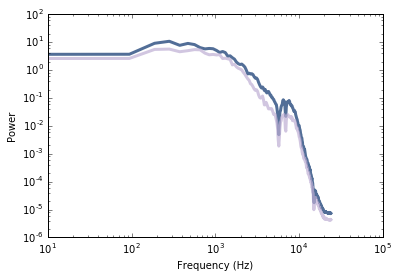

In [11]:
psd = bartlett_method(segment)
psd2 = bartlett_method(segment2)

psd.plot_power()
psd2.plot_power(color='#beaed4')

thinkplot.config(xlabel='Frequency (Hz)', 
                 ylabel='Power', 
                 xscale='log', 
                 yscale='log')

Now we can see the relationship between power and frequency more clearly.  It is not a simple linear relationship, but it is consistent across different segments, even in details like the notches near 5000 Hz, 6000 Hz, and above 10,000 Hz. 

**Exercise:** At http://www.coindesk.com you can download the daily
price of a BitCoin as a CSV file.  Read this file and compute
the spectrum of BitCoin prices as a function of time.
Does it resemble white, pink, or Brownian noise?

In [12]:
df = pd.read_csv('coindesk-bpi-USD-close.csv', nrows=1625, parse_dates=[0])
ys = df.Close.values
ts = np.arange(len(ys))

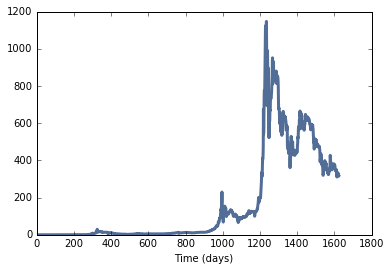

In [13]:
wave = thinkdsp.Wave(ys, ts, framerate=1)
wave.plot()
thinkplot.config(xlabel='Time (days)')

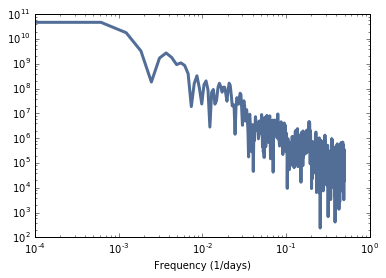

In [14]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (1/days)',
                 xscale='log', yscale='log')

The slope is -1.8, which is similar to red noise (which should have a slope of -2).

In [15]:
spectrum.estimate_slope()[0]

-1.8048752734169031

**Exercise:** A Geiger counter is a device that detects radiation. When an ionizing particle strikes the detector, it outputs a surge of current. The total output at a point in time can be modeled as uncorrelated Poisson (UP) noise, where each sample is a random quantity from a Poisson distribution, which corresponds to the number of particles detected during an interval.

Write a class called `UncorrelatedPoissonNoise` that inherits from `thinkdsp._Noise` and provides `evaluate`. It should use `np.random.poisson` to generate random values from a Poisson distribution. The parameter of this function, `lam`, is the average number of particles during each interval. You can use the attribute `amp` to specify `lam`. For example, if the framerate is 10 kHz and `amp` is 0.001, we expect about 10 “clicks” per second.

Generate about a second of UP noise and listen to it. For low values of `amp`, like 0.001, it should sound like a Geiger counter. For higher values it should sound like white noise. Compute and plot the power spectrum to see whether it looks like white noise. 

In [16]:
class UncorrelatedPoissonNoise(thinkdsp._Noise):
    """Represents uncorrelated Poisson noise."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Here's what it sounds like at low levels of "radiation".

In [17]:
amp = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

To check that things worked, we compare the expected number of particles and the actual number:

In [18]:
expected = amp * framerate * duration
actual = sum(wave.ys)
print(expected, actual)

10.0 10


Here's what the wave looks like:

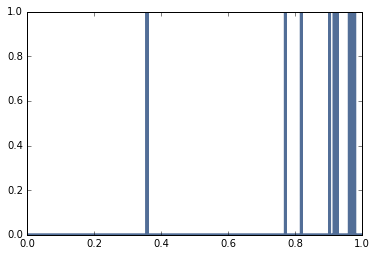

In [19]:
wave.plot()

And here's its power spectrum on a log-log scale.

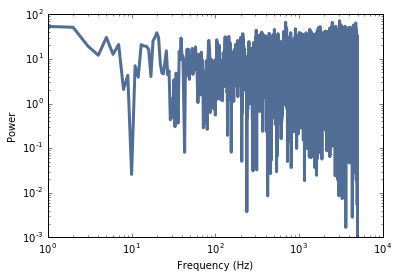

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Power',
                 xscale='log', 
                 yscale='log')

Looks like white noise, and the slope is close to 0.

In [21]:
spectrum.estimate_slope().slope

nan

With a higher arrival rate, it sounds more like white noise:

In [22]:
amp = 1
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp)
wave = signal.make_wave(duration=duration, framerate=framerate)
wave.make_audio()

It looks more like a signal:

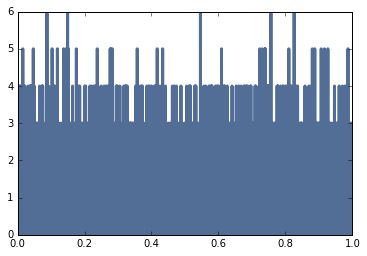

In [23]:
wave.plot()

And the spectrum converges on Gaussian noise.

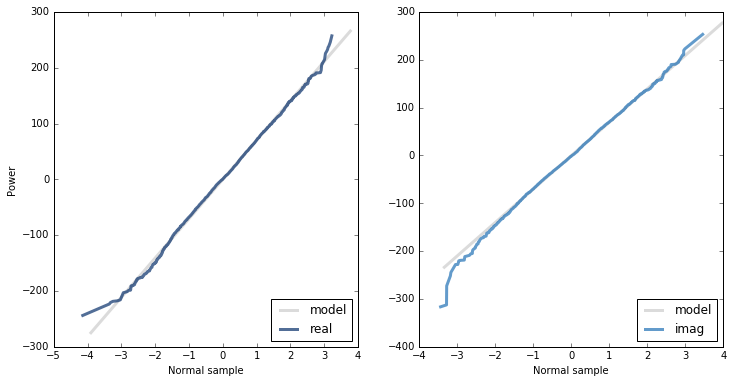

In [24]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0

thinkplot.preplot(2, cols=2)
thinkstats2.NormalProbabilityPlot(spectrum.real, label='real')
thinkplot.config(xlabel='Normal sample',
                 ylabel='Power',
                 legend=True,
                 loc='lower right')

thinkplot.subplot(2)
thinkstats2.NormalProbabilityPlot(spectrum.imag, label='imag')
thinkplot.config(xlabel='Normal sample',
                     loc='lower right')

**Exercise:** The algorithm in this chapter for generating pink noise is
conceptually simple but computationally expensive.  There are
more efficient alternatives, like the Voss-McCartney algorithm.
Research this method, implement it, compute the spectrum of
the result, and confirm that it has the desired relationship
between power and frequency.

**Solution:** The fundamental idea of this algorithm is to add up several sequences of random numbers that get updates at different sampling rates.  The first source should get updated at every time step; the second source every other time step, the third source ever fourth step, and so on.

In the original algorithm, the updates are evenly spaced.  In an alternative proposed at http://www.firstpr.com.au/dsp/pink-noise/, they are randomly spaced.

My implementation starts with an array with one row per timestep and one column for each of the white noise sources.  Initially, the first row and the first column are random and the rest of the array is Nan.

In [25]:
nrows = 100
ncols = 5

array = np.empty((nrows, ncols))
array.fill(np.nan)
array[0, :] = np.random.random(ncols)
array[:, 0] = np.random.random(nrows)
array[0:6]

array([[ 0.67651918,  0.78247984,  0.19970621,  0.74959508,  0.79686574],
       [ 0.01947641,         nan,         nan,         nan,         nan],
       [ 0.86137914,         nan,         nan,         nan,         nan],
       [ 0.99768391,         nan,         nan,         nan,         nan],
       [ 0.7667415 ,         nan,         nan,         nan,         nan],
       [ 0.79678027,         nan,         nan,         nan,         nan]])

The next step is to choose the locations where the random sources change.  If the number of rows is $n$, the number of changes in the first column is $n$, the number in the second column is $n/2$ on average, the number in the third column is $n/4$ on average, etc.

So the total number of changes in the matrix is $2n$ on average; since $n$ of those are in the first column, the other $n$ are in the rest of the matrix.

To place the remaining $n$ changes, we generate random columns from a geometric distribution with $p=0.5$.  If we generate a value out of bounds, we set it to 0 (so the first column gets the extras).

In [26]:
p = 0.5
n = nrows
cols = np.random.geometric(p, n)
cols[cols >= ncols] = 0
cols

array([0, 1, 2, 1, 2, 1, 1, 0, 2, 2, 1, 4, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 0,
       1, 1, 1, 1, 2, 1, 2, 3, 1, 1, 3, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 3,
       1, 1, 3, 1, 3, 3, 2, 1, 2, 3, 3, 2, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1,
       1, 4, 3, 1, 2, 3, 4, 1, 1, 1, 1, 2, 1, 3, 1, 4, 1, 1, 1, 2, 2, 1, 3,
       2, 2, 0, 1, 4, 2, 1, 4])

Within each column, we choose a random row from a uniform distribution.  Ideally we would choose without replacement, but it is faster and easier to choose with replacement, and I doubt it matters.

In [27]:
rows = np.random.randint(nrows, size=n)
rows

array([23, 98, 31, 67, 40, 67, 72,  9, 90, 29, 29, 34, 53,  2, 73, 90, 57,
       57, 82, 85, 22, 28, 34, 80, 60, 20, 49, 87, 41, 26, 45, 91, 62, 82,
       62, 84, 83, 66, 98, 46,  7, 19, 59, 76, 87, 64, 81, 11, 82, 40, 29,
       66, 86, 13,  2, 38, 85, 20, 42, 14,  8, 99, 13, 69, 53, 52,  9, 54,
       94, 26, 74, 52, 84, 25, 89,  3, 75, 57, 46, 57, 58, 29, 37, 87, 90,
       28, 43, 85, 28, 65, 13, 74, 13,  3, 63, 16, 27, 21, 88, 69])

Now we can put random values at rach of the change points.

In [28]:
array[rows, cols] = np.random.random(n)
array[0:6]

array([[ 0.67651918,  0.78247984,  0.19970621,  0.74959508,  0.79686574],
       [ 0.01947641,         nan,         nan,         nan,         nan],
       [ 0.86137914,  0.76081171,  0.83727687,         nan,         nan],
       [ 0.99768391,         nan,  0.88194749,         nan,  0.4568749 ],
       [ 0.7667415 ,         nan,         nan,         nan,         nan],
       [ 0.79678027,         nan,         nan,         nan,         nan]])

Next we want to do a zero-order hold to fill in the NaNs.  NumPy doesn't do that, but Pandas does.  So I'll create a DataFrame:

In [29]:
df = pd.DataFrame(array)
df.head()

,0,1,2,3,4
0,0.676519,0.782480,0.199706,0.749595,0.796866
1,0.019476,NaN,NaN,NaN,NaN
2,0.861379,0.760812,0.837277,NaN,NaN
3,0.997684,NaN,0.881947,NaN,0.456875
4,0.766742,NaN,NaN,NaN,NaN


And then use `fillna` along the columns.

In [30]:
filled = df.fillna(method='ffill', axis=0)
filled.head()

,0,1,2,3,4
0,0.676519,0.782480,0.199706,0.749595,0.796866
1,0.019476,0.782480,0.199706,0.749595,0.796866
2,0.861379,0.760812,0.837277,0.749595,0.796866
3,0.997684,0.760812,0.881947,0.749595,0.456875
4,0.766742,0.760812,0.881947,0.749595,0.456875


Finally we add up the rows.

In [31]:
total = filled.sum(axis=1)
total.head()

0    3.205166
1    2.548123
2    4.005929
3    3.846913
4    3.615971
dtype: float64

If we put the results into a Wave, here's what it looks like:

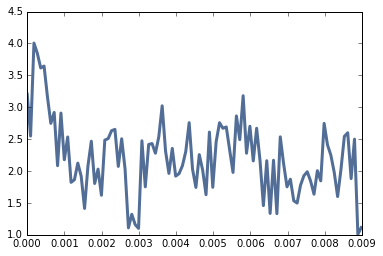

In [32]:
wave = thinkdsp.Wave(total.values)
wave.plot()

Here's the whole process in a function:

In [33]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

To test it I'll generate 11025 values:

In [34]:
ys = voss(11025)
ys

array([ 9.0222124 ,  7.07720943,  7.5834063 , ...,  6.12007538,
        7.62269653,  7.81563447])

And make them into a Wave:

In [35]:
wave = thinkdsp.Wave(ys)
wave.unbias()
wave.normalize()

Here's what it looks like:

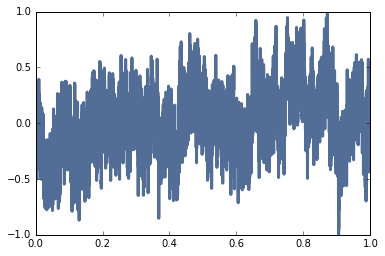

In [36]:
wave.plot()

As expected, it is more random-walk-like than white noise, but more random looking than red noise.

Here's what it sounds like:

In [37]:
wave.make_audio()

And here's the power spectrum:

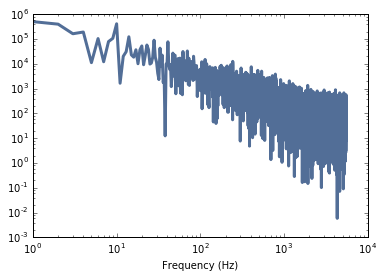

In [38]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)',
                 xscale='log', 
                 yscale='log')

The estimated slope is close to -1.

In [39]:
spectrum.estimate_slope().slope

-1.0169216785741335

We can get a better sense of the average power spectrum by generating a longer sample:

In [40]:
seg_length = 64 * 1024
iters = 100
wave = thinkdsp.Wave(voss(seg_length * iters))
len(wave)

6553600

And using Barlett's method to compute the average.

In [41]:
spectrum = bartlett_method(wave, seg_length=seg_length, win_flag=False)
spectrum.hs[0] = 0
len(spectrum)

32769

It's pretty close to a straight line, with some curvature at the highest frequencies.

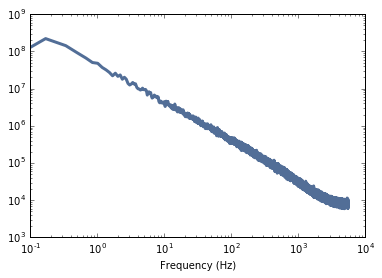

In [42]:
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)',
                 xscale='log', 
                 yscale='log')

And the slope is close to -1.

In [43]:
spectrum.estimate_slope().slope

-1.0019307825072716